In [56]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
path = 'datasets'

Mounted at /content/drive


## Visualisation

In [4]:
def visualize(res_lib, res_mod, r_min, r_max, step):

    plt.rcParams.update({'font.size': 14}) 

    R = np.arange(r_min, r_max, step)

    fig = plt.figure(figsize=(6,4), dpi=100)
    plt.plot(R, res_lib, '--', label='off-the-shelf')
    plt.plot(R, res_mod, label='modified')

    plt.grid(True)
    plt.xlabel("r")
    plt.ylabel("CV Accuracy")

    plt.legend()

    plt.show()
    fig.savefig('plot.png', dpi=300)

## Off-the-shelf R-NN implementation

In [6]:
def library_rnn(X, y, r_min=0.3, r_max=3.1, step=0.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross val

    R = np.arange(r_min, r_max, step) # range of hyperparameter r
    res = [] #stores accuracy scores for each r

    for r in R:

      scores = []

      for train_index, val_index in kf.split(X_train):

          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N, M = X_train_cv.shape[0], X_train_cv.shape[1]

          cls = RadiusNeighborsClassifier(r)
          cls.fit(X_train_cv, y_train_cv)

          labels = cls.predict(X_val_cv)
          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      acc = sum(scores)/len(scores)
      res.append(acc)
      print("For r = {} cv accuracy is {}".format(r, acc))

    best_res = max(res)
    best_r = R[np.argmax(np.array(res))]

    ### on the test set

    cls = RadiusNeighborsClassifier(best_r)
    cls.fit(X_train, y_train)
    
    labels = cls.predict(X_test)
    test_score = accuracy_score(labels, y_test)

    print("\nBest r = {} with best cv accuracy = {}\nTest accuracy = {}".format(best_r, best_res, test_score))

    return best_r, best_res, test_score, res

## Euclidean distance

In [7]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

## Manual R-NN implementation

In [9]:
def find_nn_rnn(r, x_test, X_train, y_train):

    N = X_train.shape[0]
    nn = [] # stores nearest neighbors within r

    for i in range(N):
        d = euclidean_distance(x_test, X_train[i])
        if d <= r:
            nn.append(i)
    
    preds = y_train[nn]  # labels of nearest neighbors

    values, counts = np.unique(preds, return_counts=True)

    ind = np.argmax(counts) # index of majority vote 
    
    return values[ind]

In [10]:
def manual_rnn(X, y, r_min=0.3, r_max=3.1, step=0.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    R = np.arange(r_min, r_max, step)
    res = []

    for r in R:

      scores = []

      for train_index, val_index in kf.split(X_train):

          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N = X_val_cv.shape[0]
          labels = np.zeros(N)

          for i in range(N):
              labels[i] = find_nn_rnn(r, X_val_cv[i], X_train_cv, y_train_cv)

          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      acc = sum(scores)/len(scores)
      res.append(acc)
      print("For r = {} cv accuracy is {}".format(r, acc))

    best_res = max(res)
    best_r = R[np.argmax(np.array(res))]

    ### on the test set

    N = X_test.shape[0]
    labels = np.zeros(N)

    for i in range(N):
        labels[i] = find_nn_rnn(best_r, X_test[i], X_train, y_train)

    test_score = accuracy_score(labels, y_test)

    print("\nBest r = {} with best cv accuracy = {}\nTest accuracy = {}".format(best_r, best_res, test_score))

    return best_r, best_res, test_score

## Modified R-NN

In [11]:
def compute_ri(X_train, y_train):

    data = [] # contains lists with examples' indexes belonging to the class corresponding to the index of 'data'
    classes = np.unique(y_train, return_counts=False)   # identifying classes
    num_classes = len(classes) 
    classes.sort()

    for c in classes:
        ind = np.where(y_train == c)  # list of indexes of examples corresponding to class c
        data.append(ind)

    N = X_train.shape[0]

    R = np.zeros(N) # contains the largest radii of hypershperes centered at x_i that includes only x_i's class

    for i in range(N):  # for each training example
        distances = []    # distances to points from other classes
        for c in range(num_classes):   # for all other training examples
            if c == y_train[i]:
                continue    # next class
            else:
                for ind in data[c]:
                    d = euclidean_distance(X_train[i], X_train[ind])
                    distances.append(d)

        R[i] = min(distances) # finds the r_i for x_i

    for c in classes:
        R_c = R[data[c]] # data[c] - indexes of x_i's of class c # R_c - interclass r_i's
        max_r_c = np.max(R_c) # for normalizing
        R[data[c]] = R_c / max_r_c 

    return R

In [13]:
def modified_rnn_prediction(x_test, X_train, y_train, R, r=0.4, thrs=0.5):

  N = X_train.shape[0]

  distances = np.zeros((N, 2)) # stores indexes of the examples in the 1st column, and the distances from x_test to x_i in the 2nd

  i = 0
  for x_i in X_train:
    d = euclidean_distance(x_test, x_i)
    distances[i, 0] = i
    distances[i, 1] = d
    i += 1

  distances = distances[distances[:,1].argsort()] # sort rows by distances

  nn_ind = int(distances[0,0]) # index of the nearest neighbor of x_test

  if R[nn_ind] > thrs:  # meaning r_i is large 
      prediction = y_train[nn_ind]  # perform 1-N
  else:
    nn = []   # stores global indexes of nearest neighbors located within r

    for i in range(N):
        d = euclidean_distance(x_test, X_train[i])
        if d <= r:
            nn.append(i)
            
    if len(nn) == 0:
        raise ValueError('No neighbors found. Choose larger r.')
    
    nn_y = y_train[nn]  # labels corresponding to indexes of the nearest neighbors

    classes_nn, counts = np.unique(nn_y, return_counts = True) # identify classes of the nearest neighbors

    centroids = [] # stores tuples of local centroids' classes and their coordinates

    # loop over classes that exist in my neighborhood of radius r
    for c in classes_nn:
        # for each class we get indexes
        local_ind = np.where(nn_y == c)[0]  # local indexes of nearest neighbors which have class c
        local_ind = [int(n) for n in local_ind] # ensuring indexes has to be of type int
        nn = np.array(nn) 
        global_ind = nn[local_ind] #indexes of nn of class c 
        centroids.append((c, np.mean(X_train[global_ind], axis=0)))
    
    # algorithm to find min
    min_class = -1
    min_dist = 100000
    for centroid in centroids:
        c, cpoint = centroid
        d = euclidean_distance(x_test, cpoint)
        if d < min_dist:
            min_dist = d
            min_class = c

    prediction = min_class

  return prediction

In [14]:
def modified_rnn(X, y, r_min=0.2, r_max=1, step=0.1, thrs=0.7):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    R = np.arange(r_min, r_max, step)
    res = []

    for r in R:

      scores = []

      for train_index, val_index in kf.split(X_train):

          X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
          y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

          N = X_val_cv.shape[0]
          labels = np.zeros(N)

          R_cv = compute_ri(X_train_cv, y_train_cv)
          
          for i in range(N):
              labels[i] = modified_rnn_prediction(X_val_cv[i], X_train_cv, y_train_cv, R_cv, r=r, thrs=thrs)

          score = accuracy_score(labels, y_val_cv)
          scores.append(score)

      acc = sum(scores)/len(scores)
      res.append(acc)
      print("For r = {} cv accuracy is {}".format(r, acc))

    #plt.scatter(R, res)

    best_res = max(res)
    best_r = R[np.argmax(np.array(res))]

    ### on the test set

    N = X_test.shape[0]
    labels = np.zeros(N)

    R = compute_ri(X_train, y_train)

    for i in range(N):
        labels[i] = modified_rnn_prediction(X_test[i], X_train, y_train, R, r=best_r)

    test_score = accuracy_score(labels, y_test)

    print("\nBest r = {} with best cv accuracy = {}\nTest accuracy = {}".format(best_r, best_res, test_score))

    return best_r, best_res, test_score, res

## Dataset

### Iris

In [15]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((150, 4), (150,))

In [16]:
best_r_lib_iris, best_res_lib_iris, test_score_lib_iris, res_lib_iris = library_rnn(X, y, r_min=1.4, r_max=3.1, step=0.1)

For r = 1.4 cv accuracy is 0.875
For r = 1.5 cv accuracy is 0.8583333333333334
For r = 1.6 cv accuracy is 0.85
For r = 1.7000000000000002 cv accuracy is 0.8583333333333334
For r = 1.8000000000000003 cv accuracy is 0.825
For r = 1.9000000000000004 cv accuracy is 0.8166666666666668
For r = 2.0000000000000004 cv accuracy is 0.8333333333333334
For r = 2.1000000000000005 cv accuracy is 0.7999999999999999
For r = 2.2000000000000006 cv accuracy is 0.8083333333333333
For r = 2.3000000000000007 cv accuracy is 0.8166666666666668
For r = 2.400000000000001 cv accuracy is 0.8
For r = 2.500000000000001 cv accuracy is 0.8
For r = 2.600000000000001 cv accuracy is 0.8
For r = 2.700000000000001 cv accuracy is 0.8083333333333332
For r = 2.800000000000001 cv accuracy is 0.7833333333333334
For r = 2.9000000000000012 cv accuracy is 0.7916666666666667
For r = 3.0000000000000013 cv accuracy is 0.775

Best r = 1.4 with best cv accuracy = 0.875
Test accuracy = 0.9666666666666667


In [17]:
manual_rnn(X, y, r_min=1.4, r_max=3.1, step=0.1)

For r = 1.4 cv accuracy is 0.875
For r = 1.5 cv accuracy is 0.8583333333333334
For r = 1.6 cv accuracy is 0.85
For r = 1.7000000000000002 cv accuracy is 0.8583333333333334
For r = 1.8000000000000003 cv accuracy is 0.825
For r = 1.9000000000000004 cv accuracy is 0.8166666666666668
For r = 2.0000000000000004 cv accuracy is 0.8333333333333334
For r = 2.1000000000000005 cv accuracy is 0.7999999999999999
For r = 2.2000000000000006 cv accuracy is 0.8083333333333333
For r = 2.3000000000000007 cv accuracy is 0.8166666666666668
For r = 2.400000000000001 cv accuracy is 0.8
For r = 2.500000000000001 cv accuracy is 0.8
For r = 2.600000000000001 cv accuracy is 0.8
For r = 2.700000000000001 cv accuracy is 0.8083333333333332
For r = 2.800000000000001 cv accuracy is 0.7833333333333334
For r = 2.9000000000000012 cv accuracy is 0.7916666666666667
For r = 3.0000000000000013 cv accuracy is 0.775

Best r = 1.4 with best cv accuracy = 0.875
Test accuracy = 0.9666666666666667


(1.4, 0.875, 0.9666666666666667)

In [18]:
best_r_mod_iris, best_res_mod_iris, test_score_mod_iris, res_mod_iris = modified_rnn(X, y, r_min=1.4, r_max=3.1, step=0.1, thrs=0.7)

For r = 1.4 cv accuracy is 0.95
For r = 1.5 cv accuracy is 0.95
For r = 1.6 cv accuracy is 0.9333333333333332
For r = 1.7000000000000002 cv accuracy is 0.9333333333333332
For r = 1.8000000000000003 cv accuracy is 0.925
For r = 1.9000000000000004 cv accuracy is 0.9333333333333332
For r = 2.0000000000000004 cv accuracy is 0.9416666666666667
For r = 2.1000000000000005 cv accuracy is 0.925
For r = 2.2000000000000006 cv accuracy is 0.9166666666666666
For r = 2.3000000000000007 cv accuracy is 0.8833333333333334
For r = 2.400000000000001 cv accuracy is 0.8833333333333334
For r = 2.500000000000001 cv accuracy is 0.875
For r = 2.600000000000001 cv accuracy is 0.875
For r = 2.700000000000001 cv accuracy is 0.875
For r = 2.800000000000001 cv accuracy is 0.875
For r = 2.9000000000000012 cv accuracy is 0.875
For r = 3.0000000000000013 cv accuracy is 0.875

Best r = 1.4 with best cv accuracy = 0.95
Test accuracy = 1.0


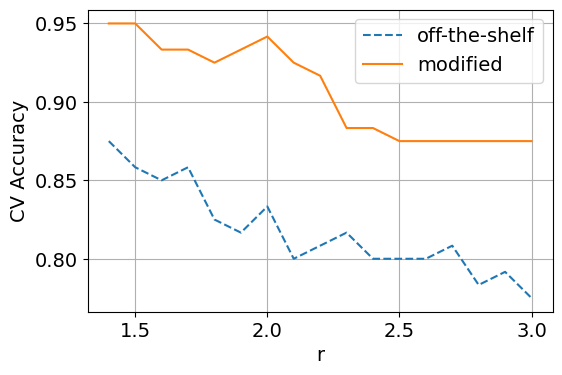

In [19]:
visualize(res_lib_iris, res_mod_iris, r_min=1.4, r_max=3.1, step=0.1)

### Wine

In [49]:
wine = datasets.load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((178, 13), (178,))

In [50]:
best_r_lib_w, best_res_lib_w, test_score_lib_w, res_lib_w = library_rnn(X, y, 4, 6, 0.1)

For r = 4.0 cv accuracy is 0.9435960591133006
For r = 4.1 cv accuracy is 0.9435960591133006
For r = 4.199999999999999 cv accuracy is 0.9576354679802955
For r = 4.299999999999999 cv accuracy is 0.9576354679802955
For r = 4.399999999999999 cv accuracy is 0.9576354679802955
For r = 4.499999999999998 cv accuracy is 0.9504926108374384
For r = 4.599999999999998 cv accuracy is 0.9435960591133006
For r = 4.6999999999999975 cv accuracy is 0.9157635467980295
For r = 4.799999999999997 cv accuracy is 0.9155172413793103
For r = 4.899999999999997 cv accuracy is 0.9157635467980295
For r = 4.9999999999999964 cv accuracy is 0.8945812807881774
For r = 5.099999999999996 cv accuracy is 0.8731527093596061
For r = 5.199999999999996 cv accuracy is 0.8307881773399014
For r = 5.299999999999995 cv accuracy is 0.8029556650246306
For r = 5.399999999999995 cv accuracy is 0.8032019704433498
For r = 5.499999999999995 cv accuracy is 0.7891625615763547
For r = 5.599999999999994 cv accuracy is 0.7756157635467981
For r 

In [52]:
manual_rnn(X, y, 4, 6, 0.1)

For r = 4.0 cv accuracy is 0.9435960591133006
For r = 4.1 cv accuracy is 0.9435960591133006
For r = 4.199999999999999 cv accuracy is 0.9576354679802955
For r = 4.299999999999999 cv accuracy is 0.9576354679802955
For r = 4.399999999999999 cv accuracy is 0.9576354679802955
For r = 4.499999999999998 cv accuracy is 0.9504926108374384
For r = 4.599999999999998 cv accuracy is 0.9435960591133006
For r = 4.6999999999999975 cv accuracy is 0.9157635467980295
For r = 4.799999999999997 cv accuracy is 0.9155172413793103
For r = 4.899999999999997 cv accuracy is 0.9157635467980295
For r = 4.9999999999999964 cv accuracy is 0.8945812807881774
For r = 5.099999999999996 cv accuracy is 0.8731527093596061
For r = 5.199999999999996 cv accuracy is 0.8307881773399014
For r = 5.299999999999995 cv accuracy is 0.8029556650246306
For r = 5.399999999999995 cv accuracy is 0.8032019704433498
For r = 5.499999999999995 cv accuracy is 0.7891625615763547
For r = 5.599999999999994 cv accuracy is 0.7756157635467981
For r 

(4.199999999999999, 0.9576354679802955, 0.9722222222222222)

In [53]:
best_r_mod_w, best_res_mod_w, test_score_mod_w, res_mod_w = modified_rnn(X, y, r_min = 4, r_max = 6, step = 0.1, thrs=0.7)

For r = 4.0 cv accuracy is 0.9440886699507389
For r = 4.1 cv accuracy is 0.9440886699507389
For r = 4.199999999999999 cv accuracy is 0.9438423645320198
For r = 4.299999999999999 cv accuracy is 0.9438423645320198
For r = 4.399999999999999 cv accuracy is 0.9369458128078818
For r = 4.499999999999998 cv accuracy is 0.9369458128078818
For r = 4.599999999999998 cv accuracy is 0.9369458128078818
For r = 4.6999999999999975 cv accuracy is 0.9369458128078818
For r = 4.799999999999997 cv accuracy is 0.9369458128078818
For r = 4.899999999999997 cv accuracy is 0.9369458128078818
For r = 4.9999999999999964 cv accuracy is 0.9440886699507389
For r = 5.099999999999996 cv accuracy is 0.9509852216748769
For r = 5.199999999999996 cv accuracy is 0.9509852216748769
For r = 5.299999999999995 cv accuracy is 0.9509852216748769
For r = 5.399999999999995 cv accuracy is 0.9509852216748769
For r = 5.499999999999995 cv accuracy is 0.9509852216748769
For r = 5.599999999999994 cv accuracy is 0.9509852216748769
For r 

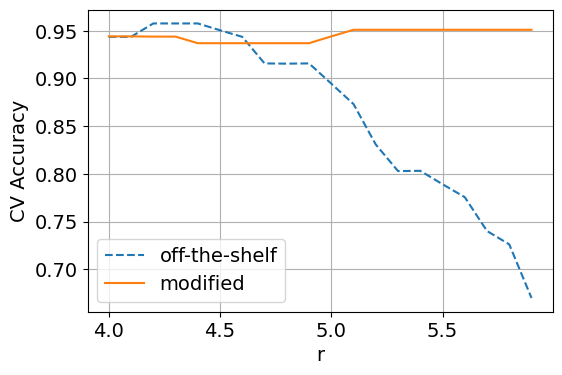

In [54]:
visualize(res_lib_w, res_mod_w, r_min = 4, r_max = 6, step = 0.1)

### Pima

In [20]:
pima = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv', 
    delimiter=',', header=None)

In [21]:
pima = pima.to_numpy()
X = pima[:, :-1]
y = pima[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((768, 8), (768,))

In [22]:
best_r_lib_p, best_res_lib_p, test_score_lib_p, res_lib_p = library_rnn(X, y, 4.5, 8, 0.1)

For r = 4.5 cv accuracy is 0.6645341863254698
For r = 4.6 cv accuracy is 0.6629214980674398
For r = 4.699999999999999 cv accuracy is 0.661295481807277
For r = 4.799999999999999 cv accuracy is 0.6661868585898973
For r = 4.899999999999999 cv accuracy is 0.6612821538051447
For r = 4.999999999999998 cv accuracy is 0.6580034652805545
For r = 5.099999999999998 cv accuracy is 0.6596428095428496
For r = 5.1999999999999975 cv accuracy is 0.6596428095428496
For r = 5.299999999999997 cv accuracy is 0.6547514327602293
For r = 5.399999999999997 cv accuracy is 0.6531254165000667
For r = 5.4999999999999964 cv accuracy is 0.6531254165000667
For r = 5.599999999999996 cv accuracy is 0.651499400239904
For r = 5.699999999999996 cv accuracy is 0.651499400239904
For r = 5.799999999999995 cv accuracy is 0.651499400239904
For r = 5.899999999999995 cv accuracy is 0.6531254165000666
For r = 5.999999999999995 cv accuracy is 0.6547514327602293
For r = 6.099999999999994 cv accuracy is 0.6563907770225244
For r = 6.

In [23]:
manual_rnn(X, y, 4.5, 8, 0.1)

For r = 4.5 cv accuracy is 0.6645341863254698
For r = 4.6 cv accuracy is 0.6629214980674398
For r = 4.699999999999999 cv accuracy is 0.661295481807277
For r = 4.799999999999999 cv accuracy is 0.6661868585898973
For r = 4.899999999999999 cv accuracy is 0.6612821538051447
For r = 4.999999999999998 cv accuracy is 0.6580034652805545
For r = 5.099999999999998 cv accuracy is 0.6596428095428496
For r = 5.1999999999999975 cv accuracy is 0.6596428095428496
For r = 5.299999999999997 cv accuracy is 0.6547514327602293
For r = 5.399999999999997 cv accuracy is 0.6531254165000667
For r = 5.4999999999999964 cv accuracy is 0.6531254165000667
For r = 5.599999999999996 cv accuracy is 0.651499400239904
For r = 5.699999999999996 cv accuracy is 0.651499400239904
For r = 5.799999999999995 cv accuracy is 0.651499400239904
For r = 5.899999999999995 cv accuracy is 0.6531254165000666
For r = 5.999999999999995 cv accuracy is 0.6547514327602293
For r = 6.099999999999994 cv accuracy is 0.6563907770225244
For r = 6.

(4.799999999999999, 0.6661868585898973, 0.6558441558441559)

In [24]:
best_r_mod_p, best_res_mod_p, test_score_mod_p, res_mod_p = modified_rnn(X, y, r_min=4.5, r_max=8, step=0.1, thrs=0.7)

For r = 4.5 cv accuracy is 0.7068905771024924
For r = 4.6 cv accuracy is 0.7036118885779021
For r = 4.699999999999999 cv accuracy is 0.7182993469278954
For r = 4.799999999999999 cv accuracy is 0.7215513794482207
For r = 4.899999999999999 cv accuracy is 0.7296681327469012
For r = 4.999999999999998 cv accuracy is 0.7280287884846062
For r = 5.099999999999998 cv accuracy is 0.7345595095295215
For r = 5.1999999999999975 cv accuracy is 0.732933493269359
For r = 5.299999999999997 cv accuracy is 0.7280421164867387
For r = 5.399999999999997 cv accuracy is 0.7313074770091964
For r = 5.4999999999999964 cv accuracy is 0.7329468212714915
For r = 5.599999999999996 cv accuracy is 0.7362255097960817
For r = 5.699999999999996 cv accuracy is 0.7313208050113288
For r = 5.799999999999995 cv accuracy is 0.7345861655337865
For r = 5.899999999999995 cv accuracy is 0.7362121817939491
For r = 5.999999999999995 cv accuracy is 0.7378381980541118
For r = 6.099999999999994 cv accuracy is 0.7345994935359189
For r =

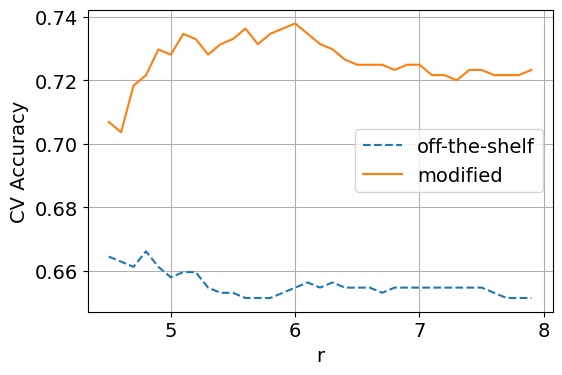

In [25]:
visualize(res_lib_p, res_mod_p, r_min=4.5, r_max=8, step=0.1)

### Ionosphere

In [26]:
io = pd.read_csv(
   os.path.join(path, 'ionosphere.data'), header = None)

In [27]:
io[34] = io[34].replace({'g':1, 'b':0})

In [28]:
io = io.to_numpy()
X = io[:, :-1]
y = io[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((351, 34), (351,))

In [29]:
best_r_lib_io, best_res_lib_io, test_score_lib_io, res_lib_io= library_rnn(X, y, 10.1, 13.1, 0.1)

For r = 10.1 cv accuracy is 0.6964285714285714
For r = 10.2 cv accuracy is 0.6928571428571428
For r = 10.299999999999999 cv accuracy is 0.6928571428571428
For r = 10.399999999999999 cv accuracy is 0.6857142857142857
For r = 10.499999999999998 cv accuracy is 0.6821428571428572
For r = 10.599999999999998 cv accuracy is 0.675
For r = 10.699999999999998 cv accuracy is 0.675
For r = 10.799999999999997 cv accuracy is 0.6714285714285715
For r = 10.899999999999997 cv accuracy is 0.6678571428571429
For r = 10.999999999999996 cv accuracy is 0.6607142857142857
For r = 11.099999999999996 cv accuracy is 0.6607142857142857
For r = 11.199999999999996 cv accuracy is 0.6607142857142857
For r = 11.299999999999995 cv accuracy is 0.6607142857142857
For r = 11.399999999999995 cv accuracy is 0.657142857142857
For r = 11.499999999999995 cv accuracy is 0.6535714285714285
For r = 11.599999999999994 cv accuracy is 0.6571428571428571
For r = 11.699999999999994 cv accuracy is 0.6535714285714285
For r = 11.7999999

In [30]:
manual_rnn(X, y, 10.1, 13.1, 0.1)

For r = 10.1 cv accuracy is 0.6964285714285714
For r = 10.2 cv accuracy is 0.6928571428571428
For r = 10.299999999999999 cv accuracy is 0.6928571428571428
For r = 10.399999999999999 cv accuracy is 0.6857142857142857
For r = 10.499999999999998 cv accuracy is 0.6821428571428572
For r = 10.599999999999998 cv accuracy is 0.675
For r = 10.699999999999998 cv accuracy is 0.675
For r = 10.799999999999997 cv accuracy is 0.6714285714285715
For r = 10.899999999999997 cv accuracy is 0.6678571428571429
For r = 10.999999999999996 cv accuracy is 0.6607142857142857
For r = 11.099999999999996 cv accuracy is 0.6607142857142857
For r = 11.199999999999996 cv accuracy is 0.6607142857142857
For r = 11.299999999999995 cv accuracy is 0.6607142857142857
For r = 11.399999999999995 cv accuracy is 0.657142857142857
For r = 11.499999999999995 cv accuracy is 0.6535714285714285
For r = 11.599999999999994 cv accuracy is 0.6571428571428571
For r = 11.699999999999994 cv accuracy is 0.6535714285714285
For r = 11.7999999

(10.1, 0.6964285714285714, 0.6338028169014085)

In [31]:
best_r_mod_io, best_res_mod_io, test_score_mod_io, res_mod_io = modified_rnn(X, y, r_min = 10.1, r_max = 13.1, step=0.1, thrs=0.7) 

For r = 10.1 cv accuracy is 0.8535714285714284
For r = 10.2 cv accuracy is 0.8535714285714284
For r = 10.299999999999999 cv accuracy is 0.8535714285714284
For r = 10.399999999999999 cv accuracy is 0.8571428571428571
For r = 10.499999999999998 cv accuracy is 0.8535714285714284
For r = 10.599999999999998 cv accuracy is 0.85
For r = 10.699999999999998 cv accuracy is 0.85
For r = 10.799999999999997 cv accuracy is 0.85
For r = 10.899999999999997 cv accuracy is 0.85
For r = 10.999999999999996 cv accuracy is 0.85
For r = 11.099999999999996 cv accuracy is 0.8535714285714284
For r = 11.199999999999996 cv accuracy is 0.8535714285714284
For r = 11.299999999999995 cv accuracy is 0.85
For r = 11.399999999999995 cv accuracy is 0.85
For r = 11.499999999999995 cv accuracy is 0.85
For r = 11.599999999999994 cv accuracy is 0.85
For r = 11.699999999999994 cv accuracy is 0.85
For r = 11.799999999999994 cv accuracy is 0.8535714285714286
For r = 11.899999999999993 cv accuracy is 0.8535714285714286
For r = 1

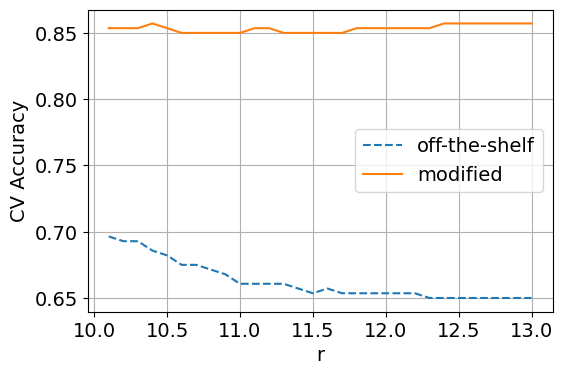

In [32]:
visualize(res_lib_io, res_mod_io, r_min=10.1, r_max=13.1, step=0.1)

### Sonar

In [33]:
sonar = pd.read_csv(
   os.path.join(path, 'sonar.all-data'), header = None)

In [34]:
sonar[60] = sonar[60].replace({'R':1, 'M':0})

In [35]:
sonar = sonar.to_numpy()
X = sonar[:, :-1]
y = sonar[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((208, 60), (208,))

In [36]:
best_r_lib_s, best_res_lib_s, test_score_lib_s, res_lib_s = library_rnn(X, y, 12.8, 15, 0.1)

For r = 12.8 cv accuracy is 0.5354723707664883
For r = 12.9 cv accuracy is 0.5595365418894831
For r = 13.0 cv accuracy is 0.5652406417112299
For r = 13.1 cv accuracy is 0.5773618538324421
For r = 13.2 cv accuracy is 0.553475935828877
For r = 13.299999999999999 cv accuracy is 0.547415329768271
For r = 13.399999999999999 cv accuracy is 0.5531194295900178
For r = 13.499999999999998 cv accuracy is 0.5654188948306595
For r = 13.599999999999998 cv accuracy is 0.5657754010695186
For r = 13.699999999999998 cv accuracy is 0.5536541889483065
For r = 13.799999999999997 cv accuracy is 0.5536541889483065
For r = 13.899999999999997 cv accuracy is 0.5657754010695186
For r = 13.999999999999996 cv accuracy is 0.5415329768270944
For r = 14.099999999999996 cv accuracy is 0.5354723707664883
For r = 14.199999999999996 cv accuracy is 0.5292335115864527
For r = 14.299999999999995 cv accuracy is 0.5354723707664883
For r = 14.399999999999995 cv accuracy is 0.5238859180035651
For r = 14.499999999999995 cv accur

In [37]:
manual_rnn(X, y, 12.8, 15, 0.1)

For r = 12.8 cv accuracy is 0.5354723707664883
For r = 12.9 cv accuracy is 0.5595365418894831
For r = 13.0 cv accuracy is 0.5652406417112299
For r = 13.1 cv accuracy is 0.5773618538324421
For r = 13.2 cv accuracy is 0.553475935828877
For r = 13.299999999999999 cv accuracy is 0.547415329768271
For r = 13.399999999999999 cv accuracy is 0.5531194295900178
For r = 13.499999999999998 cv accuracy is 0.5654188948306595
For r = 13.599999999999998 cv accuracy is 0.5657754010695186
For r = 13.699999999999998 cv accuracy is 0.5536541889483065
For r = 13.799999999999997 cv accuracy is 0.5536541889483065
For r = 13.899999999999997 cv accuracy is 0.5657754010695186
For r = 13.999999999999996 cv accuracy is 0.5415329768270944
For r = 14.099999999999996 cv accuracy is 0.5354723707664883
For r = 14.199999999999996 cv accuracy is 0.5292335115864527
For r = 14.299999999999995 cv accuracy is 0.5354723707664883
For r = 14.399999999999995 cv accuracy is 0.5238859180035651
For r = 14.499999999999995 cv accur

(13.1, 0.5773618538324421, 0.6904761904761905)

In [38]:
best_r_mod_s, best_res_mod_s, test_score_mod_s, res_mod_s = modified_rnn(X, y, r_min=12.8, r_max = 15, step = 0.1, thrs=0.7)

For r = 12.8 cv accuracy is 0.7645276292335116
For r = 12.9 cv accuracy is 0.7705882352941177
For r = 13.0 cv accuracy is 0.7645276292335115
For r = 13.1 cv accuracy is 0.7463458110516934
For r = 13.2 cv accuracy is 0.7221033868092691
For r = 13.299999999999999 cv accuracy is 0.7160427807486631
For r = 13.399999999999999 cv accuracy is 0.7279857397504456
For r = 13.499999999999998 cv accuracy is 0.7158645276292335
For r = 13.599999999999998 cv accuracy is 0.7158645276292335
For r = 13.699999999999998 cv accuracy is 0.7158645276292335
For r = 13.799999999999997 cv accuracy is 0.727807486631016
For r = 13.899999999999997 cv accuracy is 0.733868092691622
For r = 13.999999999999996 cv accuracy is 0.733868092691622
For r = 14.099999999999996 cv accuracy is 0.7399286987522281
For r = 14.199999999999996 cv accuracy is 0.7340463458110517
For r = 14.299999999999995 cv accuracy is 0.7401069518716576
For r = 14.399999999999995 cv accuracy is 0.7520499108734402
For r = 14.499999999999995 cv accura

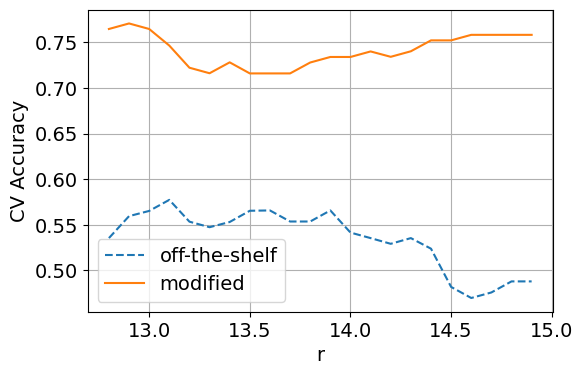

In [39]:
visualize(res_lib_s, res_mod_s, r_min=12.8, r_max=15, step=0.1)

### Liver

In [40]:
liver = pd.read_csv(
    'https://datahub.io/machine-learning/liver-disorders/r/1.csv', 
    delimiter=',')

In [41]:
liver['selector'] = liver['selector'].replace({2:1, 1:0})

In [42]:
liver = liver.to_numpy()
X = liver[:, :-1]
y = liver[:, -1].astype('int')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X.shape, y.shape

((345, 6), (345,))

In [44]:
best_r_lib_l, best_res_lib_l, test_score_lib_l, res_lib_l = library_rnn(X, y, 3.1, 5, 0.1)

For r = 3.1 cv accuracy is 0.5361688311688311
For r = 3.2 cv accuracy is 0.5505844155844156
For r = 3.3000000000000003 cv accuracy is 0.5542207792207792
For r = 3.4000000000000004 cv accuracy is 0.5614935064935065
For r = 3.5000000000000004 cv accuracy is 0.5687662337662338
For r = 3.6000000000000005 cv accuracy is 0.56512987012987
For r = 3.7000000000000006 cv accuracy is 0.5615584415584416
For r = 3.8000000000000007 cv accuracy is 0.5616233766233767
For r = 3.900000000000001 cv accuracy is 0.5615584415584416
For r = 4.000000000000001 cv accuracy is 0.5579220779220779
For r = 4.100000000000001 cv accuracy is 0.5579220779220779
For r = 4.200000000000001 cv accuracy is 0.5615584415584415
For r = 4.300000000000001 cv accuracy is 0.5579220779220778
For r = 4.400000000000001 cv accuracy is 0.5688311688311687
For r = 4.500000000000002 cv accuracy is 0.5724675324675325
For r = 4.600000000000001 cv accuracy is 0.576103896103896
For r = 4.700000000000001 cv accuracy is 0.5724675324675325
For r

In [45]:
manual_rnn(X, y, 3.1, 5, 0.1)

For r = 3.1 cv accuracy is 0.5361688311688311
For r = 3.2 cv accuracy is 0.5505844155844156
For r = 3.3000000000000003 cv accuracy is 0.5542207792207792
For r = 3.4000000000000004 cv accuracy is 0.5614935064935065
For r = 3.5000000000000004 cv accuracy is 0.5687662337662338
For r = 3.6000000000000005 cv accuracy is 0.56512987012987
For r = 3.7000000000000006 cv accuracy is 0.5615584415584416
For r = 3.8000000000000007 cv accuracy is 0.5616233766233767
For r = 3.900000000000001 cv accuracy is 0.5615584415584416
For r = 4.000000000000001 cv accuracy is 0.5579220779220779
For r = 4.100000000000001 cv accuracy is 0.5579220779220779
For r = 4.200000000000001 cv accuracy is 0.5615584415584415
For r = 4.300000000000001 cv accuracy is 0.5579220779220778
For r = 4.400000000000001 cv accuracy is 0.5688311688311687
For r = 4.500000000000002 cv accuracy is 0.5724675324675325
For r = 4.600000000000001 cv accuracy is 0.576103896103896
For r = 4.700000000000001 cv accuracy is 0.5724675324675325
For r

(4.600000000000001, 0.576103896103896, 0.6086956521739131)

In [47]:
best_r_mod_l, best_res_mod_l, test_score_mod_l, res_mod_l = modified_rnn(X, y, r_min = 3.1, r_max = 5,step = 0.1, thrs=0.7)

For r = 3.1 cv accuracy is 0.6088961038961038
For r = 3.2 cv accuracy is 0.6159740259740258
For r = 3.3000000000000003 cv accuracy is 0.6196103896103897
For r = 3.4000000000000004 cv accuracy is 0.6160389610389612
For r = 3.5000000000000004 cv accuracy is 0.6051298701298701
For r = 3.6000000000000005 cv accuracy is 0.5942207792207792
For r = 3.7000000000000006 cv accuracy is 0.6015584415584415
For r = 3.8000000000000007 cv accuracy is 0.5834415584415585
For r = 3.900000000000001 cv accuracy is 0.597987012987013
For r = 4.000000000000001 cv accuracy is 0.6051948051948052
For r = 4.100000000000001 cv accuracy is 0.5870129870129871
For r = 4.200000000000001 cv accuracy is 0.5870779220779221
For r = 4.300000000000001 cv accuracy is 0.5834415584415584
For r = 4.400000000000001 cv accuracy is 0.5762987012987013
For r = 4.500000000000002 cv accuracy is 0.5977272727272728
For r = 4.600000000000001 cv accuracy is 0.6013636363636363
For r = 4.700000000000001 cv accuracy is 0.593961038961039
For 

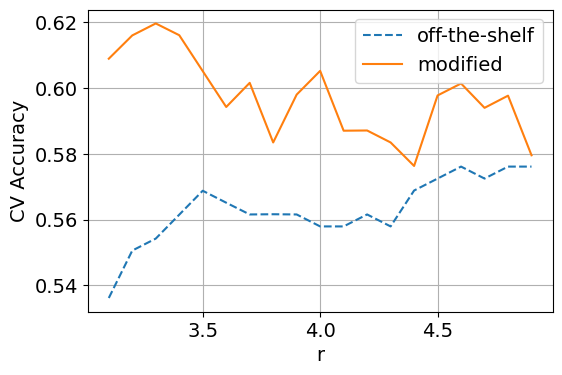

In [48]:
visualize(res_lib_l, res_mod_l, r_min = 3.1, r_max = 5, step = 0.1)